<a href="https://colab.research.google.com/github/DannyRMoreno28/Big-Data/blob/main/Analisis_basico_Big_Data_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Explorando el comportamiento de las ventas en una tienda en línea de cosméticos: un análisis de 12 millones de registros**

*Autor*

Danny Alexander Rojas Moreno

> [LinkedIn](https://www.linkedin.com/in/danny-alexander-rojas-moreno-a343a2196/)

> dannymoreno.2805@gmail.com

#**1. Instalación de herramientas**

##1.1. Instalación libreria _PySpark_ 

In [ ]:
# Instalamos el OpenJDK 8 con apt-get.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Configuramos la variable de entorno de Java.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Instalamos los paquetes de PySpark.
!pip install -q pyspark
!pip install -q findspark

##1.2. Instalación de dependencias

In [ ]:
 # Importamos pyspark
import pyspark

In [ ]:
# Librerías básicas de análisis de datos.
import numpy as np
import pandas as pd

In [ ]:
# Librerías básicas para graficar datos.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import dayofmonth
from sklearn.metrics import mean_squared_error

##1.2. Crear la sesion en la aplicacion Spark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('finalproject')\
     .config('spark.master', 'local[4]')\
     .config('spark.shuffle.sql.partitions', 1)\
     .getOrCreate()

### Comprencion
## linea 1: crear el punto de entrada a la aplicacion Spark desde Python
## linea 2: crear Spark session en mi portatil con 4 nucleos (modo cliente)
## linea 3: shuffle hace perticiones para lograr un intercambio de datos entre tablas

In [ ]:
# Mostras las caracteristicas del SparkSession
spark

#**2. Entendimiento de los datos**

##2.1. Adquisición e integración de los datos

El conjunto de datos que se utilizó para la realización de este proyecto proviene de Kaggel y representan los diferentes eventos en la venta de productos de una tienda online de cosméticos. La base de datos contiene registros del comportamiento durante 3 meses (octubre a diciembre de 2019).

Cada fila del archivo representa un evento. Todos los eventos están relacionados con productos y usuarios. Cada evento es como una relación de muchos a muchos entre productos y usuarios.

A continuación, se hace una breve descripción de las diferentes variables que componen el conjunto de datos:

*   **event_time**: fecha en que ocurrió el evento;
*   **event_type**: tipo de evento (compra, ver, en carrito, remover del carrito);
*   **product_id**: identificación única de los productos comercializados;
*   **category_id**: identificación de la categoría a la que pertenecen los productos;
*   **category_code**: no presento importancia en este análisis;
*   **brand**: marca del producto;
*   **price**: Precio de venta del producto; y
*   **user_id**: identificación única del cliente (comprador).


Para mayor información acerca de la base de datos puede acceder al siguiente link para descargar [Kaggel](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop).






**Cargar base de datos**

In [ ]:
# Cargar y leeer los archivos csv y crear DataFrames en el formato Spark 
df_dec = spark.read.csv("/content/2019-Dec.csv", inferSchema = True, header = True) # Diciembre 2019
df_nov = spark.read.csv("/content/2019-Nov.csv", inferSchema = True, header = True) # Noviembre 2019
df_oct = spark.read.csv("/content/2019-Oct.csv", inferSchema = True, header = True) # Octubre 2019

##2.2. Análisis exploratorio


En este ítem del proyecto se emplearon métodos estadísticos descriptivos, junto a la visualización de datos para poder comprender de manera superficial el comportamiento de los datos que componen la BD estudio. Cabe resaltar, que debido a lo extensa que es la base de datos, en el análisis exploratorio nos enfocamos única y exclusivamente en el comportamiento de las vetas (purchase). De este modo, pasamos de una base de datos que contenía cerca de 12.271.406 de registros en total a 781.217 registros que representan únicamente las ventas realizadas entre los meses de octubre a diciembre de 2019.

>Número de registros por DF

In [ ]:
#Mostrar las primeras 3 lineas que conformar el df_dec (datos de diciembre 2019).
df_dec.limit(5).show()
regDec = df_dec.count()
print("La base de datos del mes de diciembre contiene %d registos." % df_dec.count())

+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|    brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|2019-12-01 00:00:00|remove_from_cart|   5712790|1487580005268456287|         null|    f.o.x| 6.27|576802932|51d85cb0-897f-48d...|
|2019-12-01 00:00:00|            view|   5764655|1487580005411062629|         null|      cnd|29.05|412120092|8adff31e-2051-489...|
|2019-12-01 00:00:02|            cart|      4958|1487580009471148064|         null|   runail| 1.19|494077766|c99a50e8-2fac-4c4...|
|2019-12-01 00:00:05|            view|   5848413|1487580007675986893|         null|freedecor| 0.79|348405118|722ffea5-73c0-492...|
|2019-12-01 00:00:07|            view|   5824148|1487580005511725929|         null|

In [ ]:
# Mostrar las primeras 3 lineas que conformar el df_nov (datos de noviembre 2019).
df_nov.limit(5).show()
regNov = df_nov.count()
print("La base de datos del mes de noviembre contiene %d registos." % df_nov.count())

+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-11-01 00:00:02|            view|   5802432|1487580009286598681|         null|    null| 0.32|562076640|09fafd6c-6c99-46b...|
|2019-11-01 00:00:09|            cart|   5844397|1487580006317032337|         null|    null| 2.38|553329724|2067216c-31b5-455...|
|2019-11-01 00:00:10|            view|   5837166|1783999064103190764|         null|     pnb|22.22|556138645|57ed222e-a54a-490...|
|2019-11-01 00:00:11|            cart|   5876812|1487580010100293687|         null|jessnail| 3.16|564506666|186c1951-8052-4b3...|
|2019-11-01 00:00:24|remove_from_cart|   5826182|1487580007483048900|         null|    nul

In [ ]:
# Mostrar las primeras 3 lineas que conformar el df_nov (datos de noviembre 2019).
df_oct.limit(5).show()
regOct = df_oct.count()
print("La base de datos del mes de octubre contiene %d registos." % df_oct.count())

+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code| brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|2019-10-01 00:00:00|      cart|   5773203|1487580005134238553|         null|runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|      cart|   5773353|1487580005134238553|         null|runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|      cart|   5881589|2151191071051219817|         null|lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|      cart|   5723490|1487580005134238553|         null|runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|      cart|   5881449|1487580013522845895|         null|lovely| 0.56|429681830|49e8d843-adf3-428...|
+-------------------+---

In [ ]:
# Crear listas con las caracteristicas de cada archivo csv
columnas = ['Año', 'Mes', 'N° registros']
registros = [(2019, 'Diciembre', regDec), 
             (2019, 'Noviembre', regNov), 
             (2019, 'Octubre', regOct)]

>**Tabla del número de registros existentes por mes**

In [ ]:
# Crear dataframe con Spark q muestre en numero de registros por mes y año
dfCont = spark.createDataFrame(registros, schema = columnas)
dfCont.show()

+----+---------+------------+
| Año|      Mes|N° registros|
+----+---------+------------+
|2019|Diciembre|     3533286|
|2019|Noviembre|     4635837|
|2019|  Octubre|     4102283|
+----+---------+------------+



In [ ]:
# Importamos libreria que permite usar funciones matematicas (ej: sum, mean, max, min) 
# pyspark.sql --> Structured Data
from pyspark.sql.functions import *

In [ ]:
# Sumatoria del numero de registros existentes en el periodo analizado 
dfCont.agg({'N° registros': 'sum'}).collect()[0][0]

12271406

> Nombre de cada columna que conforman los dataframe

In [ ]:
# Verificamos los tipos inferidos imprimiendo el esquema de cada archivo.

print('Columnas --> df_dic')
df_dec.printSchema()
print('Columnas -->  df_nov')
df_nov.printSchema()
print('Columnas -->  df_oct')
df_oct.printSchema()

Columnas --> df_dic
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

Columnas -->  df_nov
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

Columnas -->  df_oct
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |

> Valores unicos en los estados de compra

In [ ]:
# Mostrar Valores unicos en la columna "event_type"
df_dec.select("event_type").distinct().show()

+----------------+
|      event_type|
+----------------+
|        purchase|
|            view|
|            cart|
|remove_from_cart|
+----------------+



In [ ]:
# Contabilizar y mostrar valores unicos
df_dec.groupBy('event_type').count().show()

+----------------+-------+
|      event_type|  count|
+----------------+-------+
|        purchase| 213176|
|            view|1728331|
|            cart| 927124|
|remove_from_cart| 664655|
+----------------+-------+



###2.2.1. Analisis descriptivo de las venta

In [ ]:
# Crear DF con todos los productos vendidos en el mes de diciembre

df_sales_dec = df_dec.filter((df_dec.event_type).isin(['purchase'])) #filtarmos por la columna "event_type" los registros 'purchase'
df_sales_dec.limit(5).show()

+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code| brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|2019-12-01 00:17:50|  purchase|      4554|1487580010796548183|         null|runail| 0.38|473613801|d1e90c6a-c030-4d0...|
|2019-12-01 00:17:50|  purchase|      4600|1487580010796548183|         null|runail| 0.38|473613801|d1e90c6a-c030-4d0...|
|2019-12-01 00:17:50|  purchase|      4607|1487580010796548183|         null|runail| 0.38|473613801|d1e90c6a-c030-4d0...|
|2019-12-01 00:17:50|  purchase|      4640|1487580011157258342|         null|runail| 0.37|473613801|d1e90c6a-c030-4d0...|
|2019-12-01 00:17:50|  purchase|      4689|1487580010796548183|         null|runail| 0.38|473613801|d1e90c6a-c030-4d0...|
+-------------------+---

In [ ]:
# Otra manera de filtral
#df_sales_dec = df_dec.filter(df_dec['event_type']=='purchase').show()

In [ ]:
# Analisis descriptivo de las ventas realizadas en diciembre 2019

df_sales_dec.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           213176|
|   mean|5.055094616654666|
| stddev|9.066076783528247|
|    min|           -79.37|
|    max|           327.78|
+-------+-----------------+



In [ ]:
# Crear DF con todos los productos vendidos en el mes de noviembre

df_sales_nov = df_nov.filter((df_nov.event_type).isin(['purchase'])) #filtarmos por la columna "event_type" los registros 'purchase'
df_sales_nov.limit(5).show()

+-------------------+----------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|    brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+---------+-----+---------+--------------------+
|2019-11-01 00:01:57|  purchase|   5839412|1487580006551913373|         null|   lovely| 3.16|460304619|9f777569-bdf3-47e...|
|2019-11-01 00:01:57|  purchase|   5823969|1487580005268456287|         null|      uno|17.46|460304619|9f777569-bdf3-47e...|
|2019-11-01 00:01:57|  purchase|   5810480|1487580011283087468|         null|     null|22.54|460304619|9f777569-bdf3-47e...|
|2019-11-01 00:04:33|  purchase|     24380|1487580012994363565|         null|depilflax| 5.24|564451209|861ab2f1-b2e5-886...|
|2019-11-01 00:04:33|  purchase|     26765|1487580013522845895|         null|   ardell| 7.16|564451209|861ab2f1-b2e5-886...|


In [ ]:
# Analisis descriptivo de las ventas realizadas en noviembre 2019

df_sales_nov.describe('price').show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            322417|
|   mean|4.7485613351652285|
| stddev| 8.785150357806241|
|    min|            -79.37|
|    max|            311.38|
+-------+------------------+



In [ ]:
# Crear DF con todos los productos vendidos en el mes de noviembre

df_sales_oct = df_oct.filter((df_oct.event_type).isin(['purchase'])) #filtarmos por la columna "event_type" los registros 'purchase'
df_sales_oct.limit(5).show()

+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code| brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+------+-----+---------+--------------------+
|2019-10-01 00:06:35|  purchase|   5619862|1487580006895846315|         null|runail| 5.32|474232307|445f2b74-5e4c-427...|
|2019-10-01 00:06:35|  purchase|   5619866|1487580006895846315|         null|runail| 2.86|474232307|445f2b74-5e4c-427...|
|2019-10-01 00:06:35|  purchase|   5696184|1487580005134238553|         null|runail| 2.38|474232307|445f2b74-5e4c-427...|
|2019-10-01 00:06:35|  purchase|   5706784|1487580005092295511|         null|runail| 4.44|474232307|445f2b74-5e4c-427...|
|2019-10-01 00:06:35|  purchase|   5723503|1487580005134238553|         null|runail| 2.62|474232307|445f2b74-5e4c-427...|
+-------------------+---

In [ ]:
# Analisis descriptivo de las ventas realizadas en noviembre 2019

df_sales_oct.describe('price').show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           245624|
|   mean|4.932492061036379|
| stddev|8.955012576338564|
|    min|           -79.37|
|    max|           299.81|
+-------+-----------------+



In [ ]:
# Almacenar el conteo de numero de ventas realizados en cada mes analizado
salesAcouDec = df_sales_dec.count()
salesAcouNov = df_sales_nov.count()
salesAcouOct = df_sales_oct.count()

In [ ]:
### ASI NO SIRVE, arroja un objeto tipo lista ###
# Almacenar la sumatoria de ventas para cada mes analizado
# salesDec = df_sales_dec.select(sum('price'))
# salesNov = df_sales_nov.select(sum('price'))
# salesOct = df_sales_oct.select(sum('price'))

In [ ]:
# Almacenar la sumatoria de ventas para cada mes analizado

salesDec = df_sales_dec.agg({'price': 'sum'}).collect()[0][0]
salesNov = df_sales_nov.agg({'price': 'sum'}).collect()[0][0]
salesOct = df_sales_oct.agg({'price': 'sum'}).collect()[0][0]

In [ ]:
# Crear listas con las caracteristicas de cada archivo csv
registroVentas = [(2019, 'Diciembre', salesAcouDec, salesDec), 
             (2019, 'Noviembre', salesAcouNov, salesNov), 
             (2019, 'Octubre', salesAcouOct, salesOct)]

In [ ]:
from pyspark.sql.types import *

schema_1 = StructType(
    [
        StructField('Año', IntegerType(), True),
        StructField('Mes', StringType(), True),
        StructField('N° ventas', IntegerType(), True),
        StructField('Valor (US$)', DoubleType(), True),     
    ]
)

>**Tabla del número de ventas y valores monetarios de las mismas por mes**

In [ ]:
# Crear dataframe con Spark q muestre en numero de registros por mes y año
dfSales = spark.createDataFrame(registroVentas, schema = schema_1)
dfSales.show()

+----+---------+---------+------------------+
| Año|      Mes|N° ventas|       Valor (US$)|
+----+---------+---------+------------------+
|2019|Diciembre|   213176|1077624.8499999752|
|2019|Noviembre|   322417|1531016.8999999675|
|2019|  Octubre|   245624|1211538.4299999997|
+----+---------+---------+------------------+



In [ ]:
# Numero transacciones (ventas) realizadas en el periodo analizado
dfSales.agg({'N° ventas': 'sum'}).collect()[0][0]

781217

In [ ]:
# Valor total de ventas en el periodo analizado
dfSales.agg({'Valor (US$)': 'sum'}).collect()[0][0]

3820180.1799999424

Observamos que el número de transacciones realizadas entre los 3 meses analizados fue de 781.217 registros que representan únicamente las ventas realizadas entre los meses de octubre a diciembre de 2019. Por otro lado, el valor de dichas ventas representó un total de U$ 3.820.178.

### 2.2.2. Visualización del comportamiento de las ventas 

Para poder visualizar los datos convertimos los dataframes tipo Spark a Pandas, de esta manera concatenamos los registros de los 3 meses a analizar y procedemos a graficar su comportamiento para un mejor entendimiento del dataset.

In [ ]:
# Crear dataframe para cada mes a analizar y convertir los dataframes a tipo Pandas.

df_pd_sales_dec = df_sales_dec.drop('product_id', 'category_id', 'brand', 'category_code', 'user_session').toPandas()
print(type(df_pd_sales_dec))
df_pd_sales_nov = df_sales_nov.drop('product_id', 'category_id', 'brand', 'category_code', 'user_session').toPandas()
print(type(df_pd_sales_nov))
df_pd_sales_oct = df_sales_oct.drop('product_id', 'category_id', 'brand', 'category_code', 'user_session').toPandas()
print(type(df_pd_sales_oct))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Crear un darafarme tipo Pandas que contiene las ventas realizadas en todos los meses

df_pd_sales_total = pd.concat([df_pd_sales_dec, df_pd_sales_nov, df_pd_sales_oct], axis=0)
df_pd_sales_total.head(5)

,event_time,event_type,price,user_id
0,2019-12-01 00:17:50,purchase,0.38,473613801
1,2019-12-01 00:17:50,purchase,0.38,473613801
2,2019-12-01 00:17:50,purchase,0.38,473613801
3,2019-12-01 00:17:50,purchase,0.37,473613801
4,2019-12-01 00:17:50,purchase,0.38,473613801


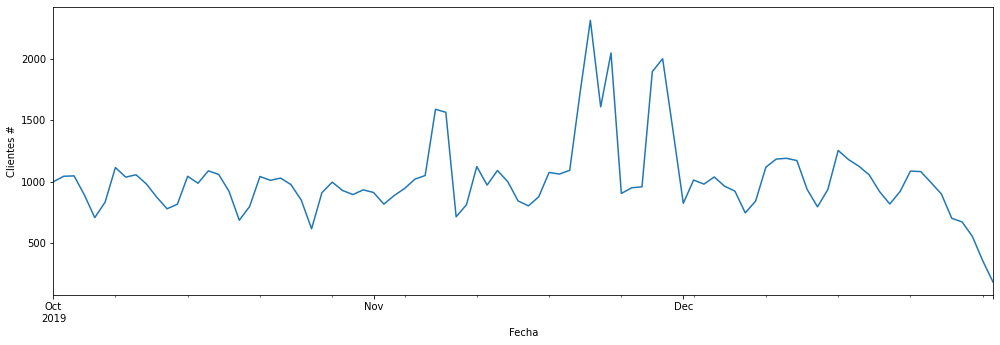

In [ ]:
# Grafico temporal del flujo de clientes que realizaron compras durante el periodo de estudio 

plt.figure(figsize = (15,10))
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user = df_pd_sales_total.resample("D", on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind ='line')
plt.xlabel('Fecha')
plt.ylabel('Clientes #');

En el anterior grafico podemos observar que es de noviembre se presentaron 4 grandes picos que representan mayor flujo de clientes que realizaron compras en el periodo analizado.

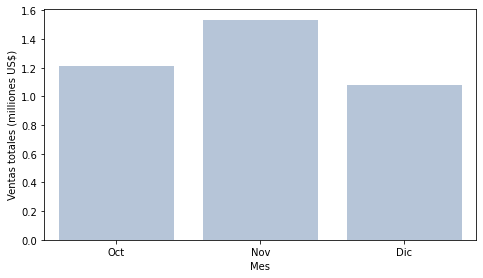

In [ ]:
# Grafico de ventas mensuales totales durante el perio de estudio

plt.figure(figsize = (15,10))
plt.axes([0.08,0,0.4,0.32])
a = df_pd_sales_total.resample('M', on = 'event_time')['price'].sum().to_frame()
a['month'] = ['Oct','Nov', 'Dic']
a['price'] = a['price']/1000000
sns.barplot(x = 'month', y = 'price', data = a, color = "lightsteelblue")
plt.xlabel('Mes')
plt.ylabel('Ventas totales (milliones US$)');

En este grafico observamos que noviembre fue el mejor mes en ventas, presentando serca de 1,5 millones de dolares en ventas. Este comportamiento es respaldado por un mayor flujo de clientes en dicho mes y que puede ser corronorado en la grafica de serie temporal.

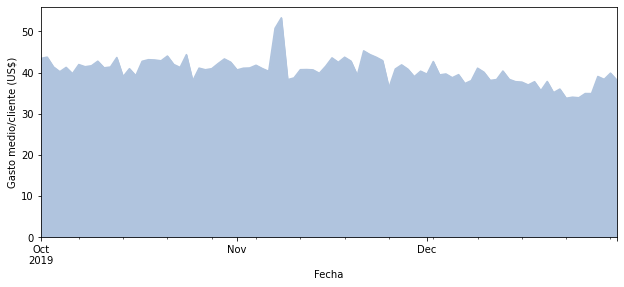

In [ ]:
#Grafico temporal del valor promedio de compras por cliente durante el periodo de estudio

plt.figure(figsize = (20,10))
plt.axes([0.55, 0, 0.4, 0.32])
df_sales_p_day = df_pd_sales_total.resample('D', on = 'event_time')['price'].sum()
df_sales_spent = df_sales_p_day / df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('Fecha')
plt.ylabel('Gasto medio/cliente (US$)');

Por otro lado, en este grafico observamos que el las ventas promedio durante los 3 meses analizados oscilo entre US$ 35 y US$ 45 por cliente. Apesar de esto, podemos decir que a inicios del mes de noviembre se presento un mayor flujo de ventes, lo que seguramente influencio en los resultados positivos del mes de noviembre de 2019.

###2.2.3. Analisis de las ventas 

In [ ]:
# Verificamos el tipo de dataframe antes de usarlos (confirmamos si continuamos trabjando con Spark)
type(df_sales_dec)
type(df_sales_nov)
type(df_sales_oct)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Contabilizar los valores unicos de los productos vendidos (product_id)
produ_sales_dec = df_dec.groupBy('product_id').count()
produ_sales_nov = df_nov.groupBy('product_id').count()
produ_sales_oct = df_oct.groupBy('product_id').count()

In [ ]:
print('Número de productos unicos vendidos en mes de diciembre:',produ_sales_dec.count())
print('Número de productos unicos vendidos en mes de noviembre:',produ_sales_nov.count())
print('Número de productos unicos vendidos en mes de octubre:',produ_sales_oct.count())
print('En total se vendieron %d productos en el ultimo trimestre del año 2019'%(produ_sales_dec.count() + produ_sales_nov.count() + produ_sales_oct.count()))

Número de productos unicos vendidos en mes de diciembre: 44624
Número de productos unicos vendidos en mes de noviembre: 43419
Número de productos unicos vendidos en mes de octubre: 41899
En total se vendieron 129942 productos en el ultimo trimestre del año 2019


Observamos que en el último trimestre del 2019 se vendieron cerca de 13mil productos. Por otro lado, a pesar de que noviembre fue el mes que presento mayores ventas (US$ 1.531.016,89), encontramos que en el mes de diciembre existió mayor diversidad de productos vendidos (44.624) en relación a los otros meses analizados. 

####**Productos más vendidos**

In [ ]:
## Mostrar los 10 producto más vendidos en diciembre
produ_sales_dec.orderBy(col('count').desc()).show(10)

+----------+-----+
|product_id|count|
+----------+-----+
|   5809910|35225|
|   5809912|10875|
|   5909810| 9671|
|   5700037| 8834|
|   5802432| 8411|
|   5809911| 7637|
|   5877454| 7547|
|   5815662| 7461|
|   5854897| 7402|
|   5751422| 7309|
+----------+-----+
only showing top 10 rows



In [ ]:
## Mostrar los 10 producto más vendidos en noviembre
produ_sales_nov.orderBy(col('count').desc()).show(10)

+----------+-----+
|product_id|count|
+----------+-----+
|   5809910|31380|
|   5809912|12527|
|   5700037|11714|
|   5751422|10982|
|   5900651|10432|
|   5751383|10367|
|   5854897|10156|
|   5802432| 9985|
|   5815662| 9976|
|   5849033| 9732|
+----------+-----+
only showing top 10 rows



In [ ]:
## Mostrar los 10 producto más vendidos en octubre
produ_sales_oct.orderBy(col('count').desc()).show(10)

+----------+-----+
|product_id|count|
+----------+-----+
|   5809910|10523|
|   5892179|10076|
|   5700037| 9429|
|   5751383| 8507|
|   5877454| 8246|
|   5751422| 8208|
|   5809912| 7904|
|   5802432| 7389|
|   5809911| 7040|
|   5792800| 7016|
+----------+-----+
only showing top 10 rows



Al filtrar los registros por el ID del producto y al ordenar estos por cantidad de produtos vendido, encontramos que en los 3 meses analisados los productos con ID 5809910 y 5809912, fueron los productos más vendidos, con ventas de entre 35.000 y 12.000 unidades, respectivamente en cada mes.

####**Productos con mayor relevancia en las ventas**

In [ ]:
# Productos que representanron mayores ventas en el mes de diciembre de 2019
df_sales_dec.groupBy('product_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(10)

+----------+--------+--------------------+
|product_id|Unidades|Ventas totales (US$)|
+----------+--------+--------------------+
|   5850281|      76|  10471.280000000004|
|   5560754|      52|  10110.880000000001|
|   5809910|    1659|   8693.159999999989|
|   5751422|     548|   6000.600000000015|
|   5751383|     435|   4489.200000000006|
|   5877454|     101|   4473.289999999999|
|   5909810|     231|   4326.630000000003|
|   5846437|      95|              4297.8|
|   5849033|     394|  4066.0800000000086|
|   5792800|     394|  4066.0800000000067|
+----------+--------+--------------------+
only showing top 10 rows



In [ ]:
# Productos que representanron mayores ventas en el mes de noviembre de 2019
df_sales_nov.groupBy('product_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(10)

+----------+--------+--------------------+
|product_id|Unidades|Ventas totales (US$)|
+----------+--------+--------------------+
|   5560754|     120|  23116.719999999994|
|   5809910|    2138|  10911.229999999954|
|   5751422|     934|   9902.160000000033|
|     89343|      30|              8859.3|
|   5751383|     802|   8068.589999999986|
|   5877454|     181|             7610.23|
|   5849033|     761|   7560.059999999988|
|   5792800|     716|   7175.959999999987|
|   5850281|      50|   6687.699999999999|
|   5856186|      85|   6132.130000000001|
+----------+--------+--------------------+
only showing top 10 rows



In [ ]:
# Productos que representanron mayores ventas en el mes de octubre de 2019
df_sales_oct.groupBy('product_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(10)

+----------+--------+--------------------+
|product_id|Unidades|Ventas totales (US$)|
+----------+--------+--------------------+
|   5877454|     251|  11116.789999999995|
|   5560754|      44|             8555.36|
|   5560756|      37|   7693.780000000001|
|   5856186|      94|   7087.600000000003|
|   5751422|     644|   7051.800000000019|
|   5846437|     139|   6288.360000000001|
|   5792800|     592|   6109.439999999998|
|   5751383|     566|   5841.119999999998|
|   5855507|      73|   5782.330000000002|
|   5849033|     440|   4540.800000000004|
+----------+--------+--------------------+
only showing top 10 rows



En este breve analisis de los productos vendidos en cada mes y si participacion en las ventas totales, observamos que en el mes de noviembre el producto de ID 5560754, alcanzo a un valor en ventas de US$ 23 mil, aproximadamente. Este producto represento relevancia en las ventas totales alcanzadas para el mes de noviembre. 

####**Analisis de los mejores clientes**

In [ ]:
# Clientes que hicieron la mayor compra (US$) en mes de diciembre

df_sales_dec.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|575709540|     399|  1526.7299999999989|
|565036131|     126|  1443.9399999999996|
|586168240|     187|  1240.6700000000017|
|572081598|     122|  1085.3200000000004|
|572631412|     199|  1046.4200000000008|
+---------+--------+--------------------+
only showing top 5 rows



In [ ]:
# Clientes que compraron la mayor cantidad de productos (unidades compradas) en el mes de diciembre

df_sales_dec.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Unidades').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|575709540|     399|  1526.7299999999989|
|517825140|     376|   849.8699999999995|
|404207391|     204|  307.20000000000056|
|572631412|     199|  1046.4200000000008|
|471099630|     190|   960.1300000000018|
+---------+--------+--------------------+
only showing top 5 rows



In [ ]:
# Clientes que hicieron la mayor compra (US$) en mes de noviembre

df_sales_nov.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|557790271|     438|  2715.8699999999935|
|566576008|     236|  1056.3600000000017|
|546880217|      46|   987.5199999999999|
|570967715|     108|   904.9199999999998|
|539636703|     157|   886.7300000000001|
+---------+--------+--------------------+
only showing top 5 rows



In [ ]:
# Clientes que compraron la maor cantidad de productos (unidades compradas) en el mes de noviembre

df_sales_nov.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Unidades').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|557790271|     438|  2715.8699999999935|
|549507462|     256|   803.5899999999999|
|566576008|     236|  1056.3600000000017|
|514908450|     209|  467.60000000000105|
|540621056|     195|   532.3399999999999|
+---------+--------+--------------------+
only showing top 5 rows



In [ ]:
# Clientes que hicieron la mayor compra (US$) en mes de octubre

df_sales_oct.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Ventas totales (US$)').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|557850743|     104|  1295.4800000000005|
|561592095|      94|  1109.6999999999996|
|150318419|      95|  1104.7599999999998|
|546827800|     329|  1004.4500000000005|
|474623506|      47|   914.9100000000002|
+---------+--------+--------------------+
only showing top 5 rows



In [ ]:
# Clientes que compraron la mayor cantidad de productos (unidades compradas) en el mes de octubre

df_sales_oct.groupBy('user_id') \
  .agg(count('product_id'). alias('Unidades'), 
       sum('price').alias('Ventas totales (US$)'),
       ) \
  .sort(col('Unidades').desc()) \
  .show(5)

+---------+--------+--------------------+
|  user_id|Unidades|Ventas totales (US$)|
+---------+--------+--------------------+
|546827800|     329|  1004.4500000000005|
|549368055|     208|   903.8800000000008|
|539691934|     178|   749.0000000000002|
|438698700|     163|  175.73000000000005|
|563301515|     159|   322.6199999999998|
+---------+--------+--------------------+
only showing top 5 rows



En las tablas que fueron presentadas anteriormente, podemos observar que los mejores 5 clientes en cada mes son diferentes, lo que demuesta la existencia de un buen numero de clientes que adquieren los productos. 

#**3. Machine learning con _PySpark_**

* Seleccionamos las columnas a trabajar para realizar el entrenamiento y pruebas, se agrupa por cada mes la suma de los datos de ventas por día de mes, y concatenamos los resultados de los 3 meses para obtener un listado unificado.

In [ ]:
DataN1=df_dec.groupBy(dayofmonth("event_time").alias("Day_of_month")).agg(sum("price").alias("Venta_total_dia"))
DataN2=df_nov.groupBy(dayofmonth("event_time").alias("Day_of_month")).agg(sum("price").alias("Venta_total_dia"))
DataN3=df_oct.groupBy(dayofmonth("event_time").alias("Day_of_month")).agg(sum("price").alias("Venta_total_dia"))
Join=DataN1.union(DataN2)
DataN=Join.union(DataN3)
DataN.show()

+------------+------------------+
|Day_of_month|   Venta_total_dia|
+------------+------------------+
|           1|1102153.5499998953|
|           6|1059341.0999999165|
|           3|1172935.1099999545|
|           5|1124082.7299999814|
|           4| 1241777.629999952|
|           7| 954734.0799999522|
|           2|1184561.8999999783|
|          12|1116291.8899998749|
|          13| 999632.3899998261|
|           9|1257598.1299998122|
|           8| 1061551.049999937|
|          10|1228395.4699999092|
|          11|1190146.4699998428|
|          14| 953973.6299999594|
|          22| 969762.2499998864|
|          16|1247088.3599999205|
|          20| 938658.0399998903|
|          19|1064701.5899998313|
|          15|1093529.4899998752|
|          17|1185104.2899998366|
+------------+------------------+
only showing top 20 rows



* Generamos un vector donde el unico dato de entrada en este caso corresponde a la columna de día de mes.

In [ ]:
featureassembler = VectorAssembler(inputCols = ["Day_of_month"], outputCol = "Independent Features")

* Reasignamos el nombre de caracteristica independiente a día de mes.

In [ ]:
output = featureassembler.transform(DataN)
output.select("Independent Features").show()

+--------------------+
|Independent Features|
+--------------------+
|               [1.0]|
|               [6.0]|
|               [3.0]|
|               [5.0]|
|               [4.0]|
|               [7.0]|
|               [2.0]|
|              [12.0]|
|              [13.0]|
|               [9.0]|
|               [8.0]|
|              [10.0]|
|              [11.0]|
|              [14.0]|
|              [22.0]|
|              [16.0]|
|              [20.0]|
|              [19.0]|
|              [15.0]|
|              [17.0]|
+--------------------+
only showing top 20 rows



* Generamos un dataframe con nombre final_data que cumple las caracteristicas requeridas para poder continuar el proceso de modelamiento.

In [ ]:
final_data = output.select("Independent Features", "Venta_total_dia")

* Se realiza la partición de los datos 80% para entrenamiento y 20% para prueba.

In [ ]:
train_data, test_data = final_data.randomSplit([0.8, 0.2])

* Generamos un modelo de tipo regresión lienal ya que estos datos no son categoricos y deseamos encontrar si existe una relación entre los dias de la semana y las ventas diarias.

In [ ]:

regressor = LinearRegression(featuresCol = 'Independent Features', labelCol = 'Venta_total_dia')
regressor = regressor.fit(train_data)

* Procedemos a obtener las predicciones correspondientes a los datos de prueba para asi evidenciar si el modelo es efectivo.

In [ ]:
pred_results = regressor.evaluate(test_data)
P=pred_results.predictions
P.show()

+--------------------+------------------+------------------+
|Independent Features|   Venta_total_dia|        prediction|
+--------------------+------------------+------------------+
|               [7.0]| 954734.0799999522|1173074.8546642647|
|               [8.0]| 1061551.049999937| 1169475.933564968|
|              [12.0]|1116291.8899998749|1155080.2491677816|
|              [20.0]| 938658.0399998903|1126288.8803734086|
|              [25.0]| 961597.8099999222|1108294.2748769256|
|              [30.0]|  642448.519999993|1090299.6693804425|
|               [4.0]|1139616.8399999493|1183871.6179621546|
|               [9.0]| 1041612.439999972|1165877.0124656714|
|              [14.0]|1145139.1500000113|1147882.4069691882|
|              [15.0]|1051585.0699999416|1144283.4858698917|
|              [19.0]|1196425.4199999725|1129887.8014727053|
|               [6.0]|1512127.3399998653|1176673.7757635613|
|               [9.0]|1197647.2499997662|1165877.0124656714|
|              [14.0]|11

* Graficamos los datos reales de los datos de prueba y las predicciones obtenidas.

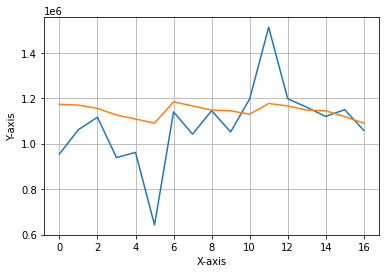

In [ ]:
y_pred = P.select("prediction").collect()
y_orig = P.select("Venta_total_dia").collect() 
plt.plot(y_orig, label="original")
plt.plot(y_pred, label="predicted")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()  

* Evaluamos el modelo.
El análisis de regresión se utiliza cuando se predice una variable de salida continua a partir de variables independientes, en este caso las predicciones y los datos reales no corresponden a datos de clasificación o descriptivos, corresponden a ventas por lo que se evalúa la capacidad predictiva.

In [ ]:
print("Coefficients: ", regressor.coefficients)
print("Intercept: ", regressor.intercept)

print("MSE: ", regressor.summary.meanSquaredError)
print("MAE: ", regressor.summary.meanAbsoluteError)
print("R-squared: ", regressor.summary.r2)
rmse = mean_squared_error(
        y_true  = y_orig,
        y_pred  = y_pred,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

Coefficients:  [-3598.921099296617]
Intercept:  1198267.302359341
MSE:  51779910021.67447
MAE:  160558.11640033673
R-squared:  0.020156695510583966

El error (rmse) de test es: 165354.18158065478


In [ ]:
# Cerrar la sesion creada en Apache Spark (closet connection to Spark).
spark.stop()

#**Conclusión**

* El uso del motor unificado de analítica Apacha Spark, permitió manejar de manera eficiente los registros contenidos en la base de datos. Así, por medio de esta tecnología y la librería de PySpark fue posible calcular el comportamiento de las ventas y los principales productos que impulsaron dichas ventas.

* Por medio del uso de filtros se logro obtener los clientes que impulsaron de manera positiva las ventas en cada uno de los meses analizados. Llegando a la conclusión de que los clientes que presentaban mayores compras era diferentes para cada mes. Sin embargo, los productos que estos adquieran eran los mismo. Es en este punto, que este tipo de información permite establecer estrategias de mercadeo más eficientes.

* A pesar de que la gráfica final en donde podemos comparar los resultados obtenidos de la predicción y los valores originales, intenta replicar su forma no logra generar valores en el rango deseado y se obtiene un R^2 cercano a 0 y un error rmse alrededor de 17000 unidades de diferencia promedio de los datos originales, indicando una baja capacidad predictiva, por lo que no es posible predecir las ventas de un día determinado con relacion al día del mes.

* Se concluye que no existe una relación entre las ventas totales diarias y los días del mes, lo que nos indicaría que las ventas no se ven influenciados por los dias del mes y que se requiere evaluar la influencia de más variables.
